In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!mkdir dataset
!unzip '/content/drive/MyDrive/Dataset/Emotions in text.zip' -d '/content/dataset'

mkdir: cannot create directory ‘dataset’: File exists
Archive:  /content/drive/MyDrive/Dataset/Emotions in text.zip
  inflating: /content/dataset/Emotion_final.csv  


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
import string

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load Dataset
dataset = pd.read_csv('/content/dataset/Emotion_final.csv')
dataset.tail()

,Text,Emotion
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear
21458,"I am dismayed , but not surpris",fear


### Preprocessing

In [5]:
# check the missing values
def missing_value(data):
    missing_data = pd.DataFrame({
        'Missing_count':data.isnull().sum(),
        'Missing_part (%)':(data.isnull().sum()/len(data))*100
    })
    missing_data = missing_data[missing_data['Missing_count']!=0]

    if len(missing_data) > 0:
        return missing_data
    else:
        return "No value is lost!!!"

In [6]:
missing_value(dataset)

'No value is lost!!!'

In [7]:
missing_value(dataset)

'No value is lost!!!'

In [8]:
# Encoded Sentiment columns
encoder = LabelEncoder()
dataset['Label'] = encoder.fit_transform(dataset['Emotion'])
dataset.tail()

,Text,Emotion,Label
21454,Melissa stared at her friend in dism,fear,1
21455,Successive state elections have seen the gover...,fear,1
21456,Vincent was irritated but not dismay,fear,1
21457,Kendall-Hume turned back to face the dismayed ...,fear,1
21458,"I am dismayed , but not surpris",fear,1


In [10]:
num_classes = dataset.Label.nunique()
print(num_classes)

6


In [11]:
def cleaning_text(text):
    stop_words = stopwords.words("english")

    text = re.sub(r'http\S+', " ", text)    # remove urls
    text = re.sub(r'@\w+',' ',text)         # remove mentions
    text = re.sub(r'#\w+', ' ', text)       # remove hastags
    text = re.sub('r<.*?>',' ', text)       # remove html tags
    
    # remove stopwords 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    
    return text

dataset['Text'] = dataset['Text'].apply(lambda x: cleaning_text(x))

In [13]:
for i in range(5):
    print('----------------------------------------------')
    random_number=np.random.randint(0,len(dataset)-1)
    print(dataset.Text[random_number])
    print('----------------------------------------------\n')

----------------------------------------------
forget time disagreement feels like wronged way every bad thing ever done life every poor choice every single thing agree comes back screaming face
----------------------------------------------

----------------------------------------------
personally well feel lethargic energy
----------------------------------------------

----------------------------------------------
im feeling really stressed work theyre piling much stuff expect creative stuff decorate make
----------------------------------------------

----------------------------------------------
feel like crappy job giving back angle due racing training schedule
----------------------------------------------

----------------------------------------------
feeling jaded
----------------------------------------------



In [14]:
# Maximum sentence length
max_len_words = max(list(dataset['Text'].apply(len)))
print(max_len_words)

232


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


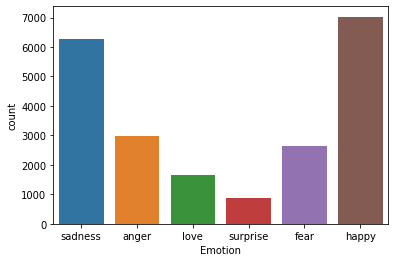

In [38]:
sns.countplot(dataset.Emotion)
plt.show()

In [52]:
def tokenizer(x_train, y_train, max_len_word):
    # because the data distribution is imbalanced, "stratify" is used
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=.2, shuffle=True, 
                                                      stratify=y_train, random_state=0)

    # Tokenizer
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    sequence_dict = tokenizer.word_index
    word_dict = dict((num, val) for (val, num) in sequence_dict.items())

    # Sequence data
    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_len_word,
                                 truncating='post',
                                 padding='post')
    
    val_sequences = tokenizer.texts_to_sequences(X_val)
    val_padded = pad_sequences(val_sequences,
                                maxlen=max_len_word,
                                truncating='post',
                                padding='post', )
    
    print(train_padded.shape)
    print(val_padded.shape)
    print('Total words: {}'.format(len(word_dict)))
    return train_padded, val_padded, y_train, y_val, word_dict

X_train, X_val, y_train, y_val, word_dict = tokenizer(dataset.Text, dataset.Label, 100)

(17167, 100)
(4292, 100)
Total words: 17099


### Model

In [66]:
model = Sequential([
    layers.Embedding(5000, 100, input_length=100),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0.4)),
    #layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),    # or layers.Flatten()
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1()),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

In [67]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 390       
Total params: 593,126
Trainable params: 593,126
Non-trainable params: 0
________________________________________________

In [68]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [69]:
import time
start = time.perf_counter()
early_stopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                         mode ="min", patience=3)

history = model.fit(X_train, y_train,
                    epochs=50, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping], 
                    shuffle=True)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/50
537/537 [==============================] - 147s 264ms/step - loss: 2.4634 - accuracy: 0.3141 - val_loss: 1.5530 - val_accuracy: 0.3276
Epoch 2/50
537/537 [==============================] - 143s 266ms/step - loss: 1.4104 - accuracy: 0.3588 - val_loss: 1.3561 - val_accuracy: 0.3751
Epoch 3/50
537/537 [==============================] - 141s 263ms/step - loss: 1.3056 - accuracy: 0.4125 - val_loss: 1.3237 - val_accuracy: 0.4152
Epoch 4/50
537/537 [==============================] - 141s 263ms/step - loss: 1.2633 - accuracy: 0.4092 - val_loss: 1.3128 - val_accuracy: 0.4005
Epoch 5/50
537/537 [==============================] - 144s 267ms/step - loss: 1.2131 - accuracy: 0.4284 - val_loss: 1.2798 - val_accuracy: 0.4208
Epoch 6/50
537/537 [==============================] - 143s 266ms/step - loss: 1.2104 - accuracy: 0.4326 - val_loss: 1.2510 - val_accuracy: 0.4280
Epoch 7/50
537/537 [==============================] - 142s 264ms/step - loss: 1.1656 - accuracy: 0.4460 - val_loss: 1.2401 -

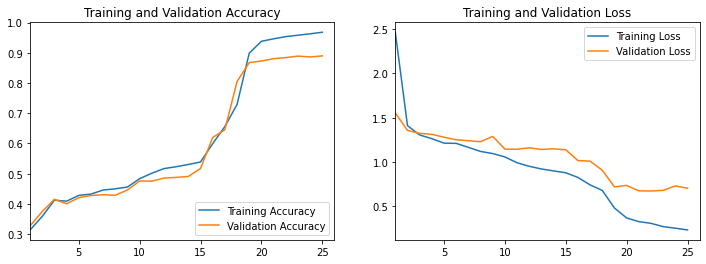

In [70]:
# Plotting accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_acc)+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Loss')
plt.show()